In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# import train test split fromo sklearn
from sklearn.model_selection import train_test_split
import pycountry_convert
from pipeline_functions import *
import copy
import warnings
from statsmodels.tsa.seasonal import seasonal_decompose

In [2]:
# dane = pd.read_excel('/Users/adammajczyk/Dokumenty-lokalne/DANE/online_retail_II.xlsx')
dane = pd.read_excel('online_retail_II.xlsx')

In [3]:
dane = initial_transform(dane)

In [4]:
dane = add_continent_and_eu_columns(dane)

In [14]:
dane

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Month,Year,Day,TotalPrice,YearMonth,Continent
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,12,2009,1,83.40,2009-12,EU_UK
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,EU_UK
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,12,2009,1,81.00,2009-12,EU_UK
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,12,2009,1,100.80,2009-12,EU_UK
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,12,2009,1,30.00,2009-12,EU_UK
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
525456,538171,22271,FELTCRAFT DOLL ROSIE,2,2010-12-09 20:01:00,2.95,17530.0,United Kingdom,12,2010,9,5.90,2010-12,EU_UK
525457,538171,22750,FELTCRAFT PRINCESS LOLA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,EU_UK
525458,538171,22751,FELTCRAFT PRINCESS OLIVIA DOLL,1,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,3.75,2010-12,EU_UK
525459,538171,20970,PINK FLORAL FELTCRAFT SHOULDER BAG,2,2010-12-09 20:01:00,3.75,17530.0,United Kingdom,12,2010,9,7.50,2010-12,EU_UK


In [15]:
#split data in train test validation 0.8 0.1 0.1
train, test = train_test_split(dane, test_size=0.2)
train, val = train_test_split(train, test_size=0.125)


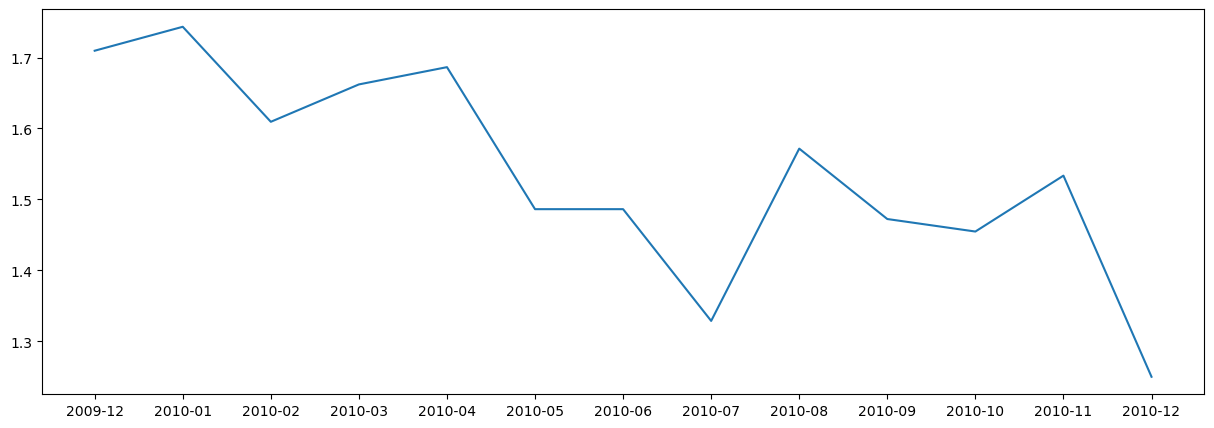

In [16]:
# plot price by date on x axis for stockcode 20979
plt.figure(figsize=(15,5))
plt.plot(train[train['StockCode'] == 20979].groupby('YearMonth')['Price'].mean())




<Figure size 1000x600 with 0 Axes>

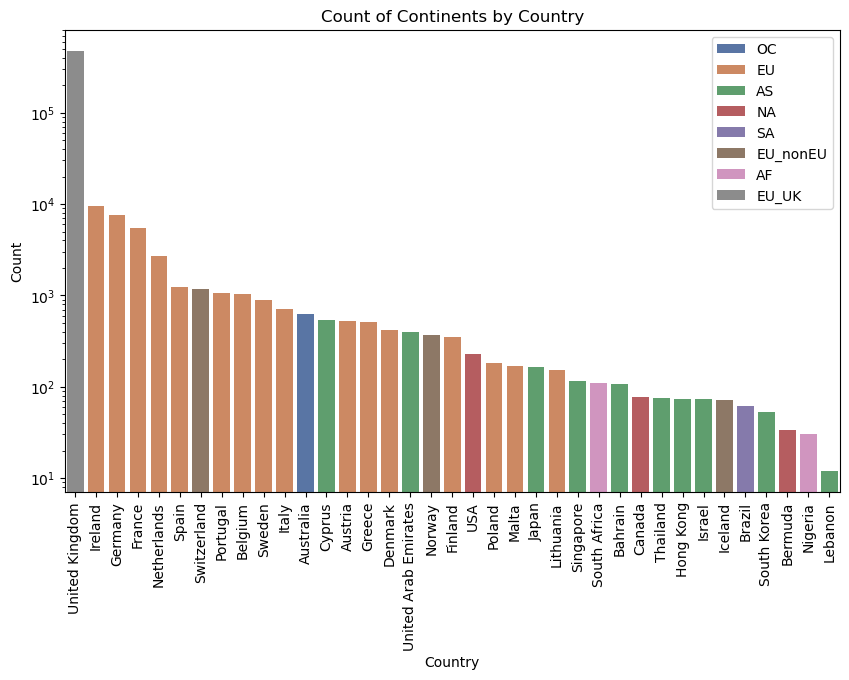

In [17]:
warnings.filterwarnings("ignore")
continent_counts = dane.groupby('Country')['Continent'].value_counts().reset_index(name='Count')
sorted_countries = continent_counts.groupby('Country').sum().sort_values(by='Count', ascending=False).index

plt.figure(figsize=(10, 6))

# Create a bar plot
plt.figure(figsize=(10, 6))

sns.barplot(x='Country', y='Count', hue='Continent', data=continent_counts,
            palette='deep', dodge=False, order=sorted_countries)

# Set labels and title
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Count of Continents by Country')
plt.yscale("log")
# Rotate x-axis labels by 90 degrees
plt.xticks(rotation=90)

# Add legend
plt.legend()

# Show the plot
plt.show()
warnings.filterwarnings("default")


In [106]:
df = copy.deepcopy(dane)

In [107]:

# Group by "Year", "Month", "StockCode", and "Continent", and calculate the sum of "Quantity"
df_grouped = df.groupby(['Year', 'Month', 'StockCode', 'Continent']).agg({'Quantity': 'sum'})

# Reset the index to convert the grouped result back to a DataFrame
df_grouped = df_grouped.reset_index()

# Group by "Year", "Month", and "StockCode" without "Continent", and calculate the sum of "Quantity"
df_grouped_without_continent = df.groupby(['Year', 'Month', 'StockCode']).agg({'Quantity': 'sum'})

# Reset the index to convert the grouped result back to a DataFrame
df_grouped_without_continent = df_grouped_without_continent.reset_index()


In [108]:
df_grouped_without_continent

,Year,Month,StockCode,Quantity
0,2009,12,10002,216
1,2009,12,10080,4
2,2009,12,10109,4
3,2009,12,10120,115
4,2009,12,10125,128
...,...,...,...,...
35412,2010,12,C2,5
35413,2010,12,DCGS0076,1
35414,2010,12,DOT,21
35415,2010,12,M,119


In [109]:
df = df_grouped_without_continent
# df = df.iloc[::-1]

In [83]:
df

,Year,Month,StockCode,Quantity
35416,2010,12,POST,98
35415,2010,12,M,119
35414,2010,12,DOT,21
35413,2010,12,DCGS0076,1
35412,2010,12,C2,5
...,...,...,...,...
4,2009,12,10125,128
3,2009,12,10120,115
2,2009,12,10109,4
1,2009,12,10080,4


In [118]:
group = df.groupby(["StockCode"])
tmp = pd.DataFrame(columns=["Year","Month","StockCode","Quantity","Mean"])
for item, item_group in group:
    print(item_group)
    # means = []
    # item_group.reset_index(drop=True,inplace=True)
    # for index in range(0,len(item_group)-3):
    #     means.append(np.mean(item_group.loc[index:index+3,"Quantity"]))
    # means += [0]*(len(item_group)-len(means))
    # item_group["Mean"] = means
    # tmp = pd.concat([tmp,item_group],axis=1)

# print(index)

# for item, item_group in group:
#     print(item_group)

C:\Users\artur\AppData\Local\Temp\ipykernel_27248\1475155077.py:3: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for item, item_group in group:


       Year  Month StockCode  Quantity         Mean  WeightedMean
0      2009     12     10002       216     0.000000    216.000000
3057   2010      1     10002       291     0.000000    253.500000
5743   2010      2     10002       257   254.666667    255.250000
8320   2010      3     10002       642   396.666667    448.625000
11208  2010      4     10002      1132   677.000000    790.312500
13800  2010      5     10002      1465  1079.666667   1127.656250
16374  2010      6     10002       463  1020.000000    795.328125
19094  2010      7     10002       512   813.333333    653.664062
21706  2010      8     10002       586   520.333333    619.832031
24390  2010      9     10002       242   446.666667    430.916016
27107  2010     10     10002      1046   624.666667    738.458008
29949  2010     11     10002       964   750.666667    851.229004
32982  2010     12     10002       160   723.333333    505.614502
       Year  Month StockCode  Quantity      Mean  WeightedMean
1      2009  

In [ ]:
tmp

In [116]:
df["Mean"] = df.groupby("StockCode")["Quantity"].rolling(window=3).mean().reset_index(level=0, drop=True)
df["WeightedMean"] = df.groupby("StockCode")["Quantity"].ewm(span=3, adjust=False).mean().reset_index(level=0, drop=True)
df.fillna(0,inplace=True)

In [117]:
df

,Year,Month,StockCode,Quantity,Mean,WeightedMean
0,2009,12,10002,216,0.000000,216.000000
1,2009,12,10080,4,0.000000,4.000000
2,2009,12,10109,4,0.000000,4.000000
3,2009,12,10120,115,0.000000,115.000000
4,2009,12,10125,128,0.000000,128.000000
...,...,...,...,...,...,...
35412,2010,12,C2,5,16.666667,12.913330
35413,2010,12,DCGS0076,1,1.333333,1.296875
35414,2010,12,DOT,21,45.333333,39.898193
35415,2010,12,M,119,224.000000,205.012695


In [54]:


# Calculate weighted moving average of 'Quantity' column for last 3 months
df['WeightedMA'] = df['Quantity'].rolling('90D', min_periods=1, closed='right')
#  \
#     .apply(lambda x: (x * (90 - x.index.day)).sum() / ((90 - x.index.day).sum()), raw=False)

# Reset index to default
df.reset_index(inplace=True)

# Drop 'Year' and 'Month' columns if not needed
df.drop(['Year', 'Month'], axis=1, inplace=True)


TypeError: object of type 'Rolling' has no len()

In [14]:
items_group = {}
unique_products = dane["StockCode"].unique()
full_len = len(unique_products)
for i,product in enumerate(unique_products):
    df_ = dane[dane["StockCode"] == product] 
    df_ = df_.groupby(['Year', 'Month', 'StockCode']).agg({'Quantity': 'sum'}).reset_index()
    items_group[product] = df_
    print(f"{i}/{full_len}",end="\r")


KeyboardInterrupt: 

In [10]:
items_groupe = {}
for product in dane["StockCode"].unique():
    df_ = dane[dane["StockCode"] == product] 
    df_ = df_.groupby(['Year', 'Month', 'StockCode',"Continent"]).agg({'Quantity': 'sum'}).reset_index()
    continents_grouped[continent] = df_
    

KeyboardInterrupt: 

In [ ]:
list(continents_grouped.values())[0]

 

,Year,Month,StockCode,Continent,Quantity
0,2009,12,10002,EU_UK,108
1,2009,12,10080,EU_UK,4
2,2009,12,10109,EU_UK,4
3,2009,12,10120,EU_UK,115
4,2009,12,10125,EU_UK,128
...,...,...,...,...,...
35027,2010,12,BANK CHARGES,EU_UK,1
35028,2010,12,C2,EU_UK,2
35029,2010,12,DCGS0076,EU_UK,1
35030,2010,12,DOT,EU_UK,21


In [97]:
df = pd.concat( [df_ for key, df_ in continents_grouped.items()],axis=0)

In [ ]:
grouped_by_continent = df.groupby("Continent")
decomposition_dict = {}
for continent, continent_group in grouped_by_continent:
    grouped_by_item = continent_group.groupby('StockCode')
    for item, item_group in grouped_by_item:
        np.average(df.y - df.x, weights=df.index.asi8)
        result = seasonal_decompose(item_group['Quantity'], model='additive',two_sided=False)
        item_group['quantity_trend'] = result.trend
        item_group['quantity_seasonal'] = result.seasonal
        item_group['quantity_residual'] = result.resid

In [94]:
df

,Year,Month,StockCode,Continent,Quantity
0,2009,12,10002,EU_UK,108
1,2009,12,10080,EU_UK,4
2,2009,12,10109,EU_UK,4
3,2009,12,10120,EU_UK,115
4,2009,12,10125,EU_UK,128
...,...,...,...,...,...
56,2010,9,85023B,SA,2
57,2010,9,85024B,SA,2
58,2010,9,85123A,SA,3
59,2010,9,85124B,SA,2


In [39]:
def time_features(df):
    df['quantity_lag1'] = df['Quantity'].shift(1)
    df['quantity_lag2'] = df['Quantity'].shift(2)

    # Calculate rolling mean and standard deviation as features
    df['quantity_roll_mean'] = df['Quantity'].rolling(window=3).mean()
    df['quantity_roll_std'] = df['Quantity'].rolling(window=3).std()
    df.fillna(0,inplace=True)


In [40]:
for key,df_ in continents_grouped.items():
    time_features(df_)

In [88]:
# df['date'] = pd.to_datetime(df[['Year', 'Month']].assign(day=1))
# df.set_index('date', inplace=True)



In [89]:
df

,Year,Month,StockCode,Continent,Quantity
date,,,,,
2009-12-01,2009,12,10002,EU_UK,108
2009-12-01,2009,12,10080,EU_UK,4
2009-12-01,2009,12,10109,EU_UK,4
2009-12-01,2009,12,10120,EU_UK,115
2009-12-01,2009,12,10125,EU_UK,128
...,...,...,...,...,...
2010-09-01,2010,9,85023B,SA,2
2010-09-01,2010,9,85024B,SA,2
2010-09-01,2010,9,85123A,SA,3


In [92]:
grouped_by_continent = df.groupby("Continent")
decomposition_dict = {}
for continent, continent_group in grouped_by_continent:
    grouped_by_item = continent_group.groupby('StockCode')
    for item, item_group in grouped_by_item:
        np.average(df.y - df.x, weights=df.index.asi8)
        result = seasonal_decompose(item_group['Quantity'], model='additive',two_sided=False)
        item_group['quantity_trend'] = result.trend
        item_group['quantity_seasonal'] = result.seasonal
        item_group['quantity_residual'] = result.resid

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [ ]:
df_grouped['date'] = pd.to_datetime(df_grouped[['Year', 'Month']].assign(day=1))
df_grouped.set_index('date', inplace=True)

grouped_by_contiennt = df_grouped.grupby("Continent")

# Group by Item
grouped_by_item = df_grouped.groupby('StockCode')

# Perform seasonal decomposition for each item separately
decomposition_dict = {}
for item, group in grouped_by_item:
    result = seasonal_decompose(df_grouped['Quantity'], model='additive',two_sided=False)
    df_grouped['quantity_trend'] = result.trend
    df_grouped['quantity_seasonal'] = result.seasonal
    df_grouped['quantity_residual'] = result.resid

In [26]:

# Perform seasonal decomposition of time series
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df_grouped['Quantity'], model='additive')
df_grouped['quantity_trend'] = result.trend
df_grouped['quantity_seasonal'] = result.seasonal
df_grouped['quantity_residual'] = result.resid

ValueError: You must specify a period or x must be a pandas object with a PeriodIndex or a DatetimeIndex with a freq not set to None

In [23]:
df_grouped.fillna(0)

,Year,Month,StockCode,Continent,Quantity,quantity_lag1,quantity_lag2,quantity_roll_mean,quantity_roll_std
0,2009,12,10002,EU,108,0.0,0.0,0.000000,0.000000
1,2009,12,10002,EU_UK,108,108.0,0.0,0.000000,0.000000
2,2009,12,10080,EU_UK,4,108.0,108.0,73.333333,60.044428
3,2009,12,10109,EU_UK,4,4.0,108.0,38.666667,60.044428
4,2009,12,10120,EU_UK,115,4.0,4.0,41.000000,64.085880
...,...,...,...,...,...,...,...,...,...
51517,2010,12,DCGS0076,EU_UK,1,2.0,3.0,2.000000,1.000000
51518,2010,12,DOT,EU_UK,21,1.0,2.0,8.000000,11.269428
51519,2010,12,M,EU_UK,119,21.0,1.0,47.000000,63.150614
51520,2010,12,POST,EU,96,119.0,21.0,78.666667,51.247764


In [ ]:
import dtale

dtale.show(dane)

c:\Users\artur\miniconda3\lib\site-packages\dtale\views.py:874: DeprecationWarning:

In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`

c:\Users\artur\miniconda3\lib\site-packages\dtale\views.py:756: FutureWarning:

['Invoice', 'StockCode', 'Description'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.



In [ ]:
dtale.show(grouped_dane)

c:\Users\artur\miniconda3\lib\site-packages\dtale\views.py:756: FutureWarning:

['StockCode'] did not aggregate successfully. If any error is raised this will raise in a future version of pandas. Drop these columns/ops to avoid this warning.

